In [51]:
# Initialize Otter
import otter
grader = otter.Notebook("lab07.ipynb")

/home/codespace/.local/lib/python3.12/site-packages/nbformat/__init__.py:96: MissingIDFieldWarning: Cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)


# Lab 7: Great British Bake Off (A/B Test)

Welcome to Data 8 Lab 7! This week's lab will focus on A/B Testing using data from the ever-popular British television show, [*The Great British Bake Off*](https://en.wikipedia.org/wiki/The_Great_British_Bake_Off).

#### **Helpful Resource:**
- [Python Reference](http://data8.org/su24/reference/)

**Recommended Readings:**

* [Error Probabilities](https://inferentialthinking.com/chapters/11/4/Error_Probabilities.html)
* [A/B Testing](https://inferentialthinking.com/chapters/12/1/AB_Testing.html)

In [52]:
# Run this cell to set up the notebook, but please don't change it.

# These lines import the Numpy and Datascience modules.
import numpy as np
from datascience import *

# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
#warnings.simplefilter('ignore', (FutureWarning, np.VisibleDeprecationWarning))

## 2. The Great British Bake Off

>"The Great British Bake Off (often abbreviated to Bake Off or GBBO) is a British television baking competition, produced by Love Productions, in which a group of amateur bakers compete against each other in a series of rounds, attempting to impress a group of judges with their baking skills" [Wikipedia](https://en.wikipedia.org/wiki/The_Great_British_Bake_Off)

For every week of the competition, the judges assign one contestant the title "Star Baker". Ultimately, one winner is crowned every season. Using this information, we would like to investigate how winning Star Baker awards affects the odds of winning a season of the show.

### Running an Experiment

We are going to run the following hypothesis test to determine the association between winning and number of Star Baker awards. The population we are examining is every contestant from seasons 2 through 11 of GBBO. We are going to use the following null and alternative hypotheses:

**Null hypothesis:** The distribution of Star Baker awards between contestants who won their season and contestants who did not win their season is the same.

**Alternative hypothesis:** Contestants who win their season of the show will win more Star Baker awards on average.

Our alternative hypothesis is related to our suspicion that contestants who win more Star Baker awards are more skilled, so they are more likely to win the season.

The `bakers` table below describes the number of star baker awards each contest won and whether or not they won their season (`1` if they won, `0` if they did not win). The data was manually aggregated from Wikipedia for seasons 2-11 of the show. We randomized the order of rows as to not spoil the outcome of the show.

In [53]:
bakers = Table.read_table("star_bakers.csv")
bakers.show(3)

star baker awards,won
3,1
0,0
1,0


**Question 2.3.** Create a new table called `means` that contains the mean number of star baker awards for bakers who did not win (`won==0`) and bakers that did win (`won==1`). The table should have the column names `won` and `star baker awards mean`.

In [54]:
means = bakers.group("won", np.average).relabeled("star baker awards average", "star baker awards mean")
means

won,star baker awards mean
0,0.651786
1,1.5


In [55]:
grader.check("q2_3")

q2_3 results: All test cases passed!

**Question 2.4.** Visualize the distribution of Star Baker awards for winners and non-winners as overlaid histograms. You should use the bins we provided.

Hint: You will want to use the group argument of `tbl.hist`. In order to produce several overlayed histograms based on unique values in a given column, we can do something like `tbl.hist(..., group=<col_name>, bins=...)`. This will graph one histogram for each unique value in the specified column all on a single plot.


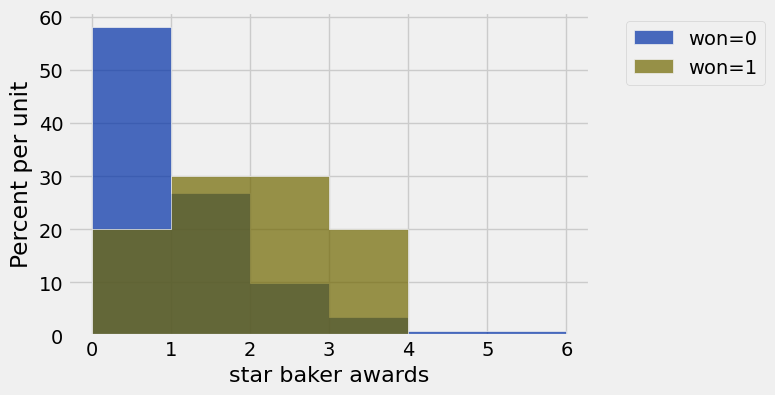

In [56]:
useful_bins = np.arange(0, 7)
bakers.hist("star baker awards", group = "won", bins = useful_bins)

**Question 2.5.** We want to figure out if there is a difference between the distribution of Star Baker awards between winners and non winners. 

What should the test statistic be? Which values of this test statistic support the null, and which values support the alternative? **Assign `test_option` to the number corresponding to the correct test statistic.**

1. Absolute value of the difference between the means between both groups; high values support the null
2. Absolute value of the difference between the means between both groups; low values support the null
3. Average Star Baker awards for winners - average Star Baker awards for non-winners; high values support the null
4. Average Star Baker awards for winners - average Star Baker awards for non-winners; low values support the null

_Hint:_ You should think about what measures we use to describe a distribution. 


In [72]:
test_option = 4

In [73]:
grader.check("q2_5")

q2_5 results: All test cases passed!

**Question 2.6.** Set `observed_difference` to the observed test statistic using the `means` table. 


In [75]:
observed_difference = means.column("star baker awards mean")[1] - means.column("star baker awards mean")[0]
observed_difference

0.8482142857142857

In [76]:
grader.check("q2_6")

q2_6 results: All test cases passed!

**Question 2.7.** Given a table like `bakers`, a label column `label_col`, and a values column `val_col`, write a function that calculates the appropriate test statistic.

*Hint:* Make sure that you are taking the directionality of our alternative hypothesis into account.


In [82]:
bakers.group("won", np.average)

won,star baker awards average
0,0.651786
1,1.5


In [83]:
# means = bakers.group("won", np.average).relabeled("star baker awards average", "star baker awards mean")
def find_test_stat(tbl, label_col, val_col):
    winners = np.average(tbl.where(label_col, 1).column(val_col))
    losers = np.average(tbl.where(label_col, 0).column(val_col))

    return winners - losers
find_test_stat(bakers, "won", "star baker awards")

0.8482142857142857

In [84]:
grader.check("q2_7")

q2_7 results: All test cases passed!

When we run a simulation for A/B testing, we resample by **shuffling the labels** of the original sample. If the null hypothesis is true and the star baker award distributions are the same, we expect that the difference in mean star baker awards to not change when `"won"` labels are changed.

**Question 2.8.** Write a function `simulate_and_test_statistic` to compute one trial of our A/B test. Your function should run a simulation and return a test statistic.


In [110]:
def simulate_and_test_statistic(tbl, labels_col, values_col):
    shuffled_labels = tbl.sample(tbl.num_rows, with_replacement = False).column(labels_col)
    shuffled_tbl = tbl.with_column(labels_col, shuffled_labels)
    grouped_means = shuffled_tbl.group(labels_col, np.average)
    return grouped_means.column(f"{values_col} average").item(1) - grouped_means.column(f"{values_col} average").item(0)

simulate_and_test_statistic(bakers, "won", "star baker awards")

-0.13214285714285712

In [105]:
grader.check("q2_8")

q2_8 results: All test cases passed!

**Question 2.9.** Simulate 5000 trials of our A/B test and store the test statistics in an array called `differences`.


In [114]:
# This cell might take a couple seconds to run
differences = make_array()

for i in np.arange(5000):
    differences = np.append(differences, simulate_and_test_statistic(bakers, "won", "star baker awards"))
                                                 
differences

array([ 0.08571429, -0.02321429,  0.19464286, ...,  0.19464286,
        0.63035714, -0.56785714])

In [115]:
grader.check("q2_9")

q2_9 results: All test cases passed!

Run the cell below to view a histogram of your simulated test statistics plotted with your observed test statistic.

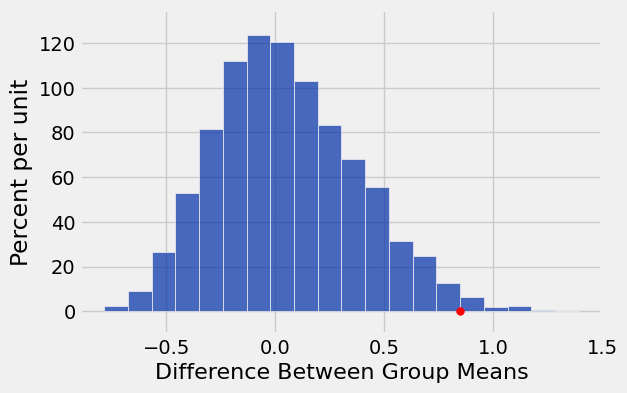

In [117]:
Table().with_column('Difference Between Group Means', differences).hist(bins=20)
plots.scatter(observed_difference, 0, color='red', s=30, zorder=2)
plots.ylim(-0.1, 1.35);

**Question 2.10.** Find the p-value for your test and assign it to `empirical_p`.


In [119]:
empirical_p = np.count_nonzero(np.abs(differences) >= observed_difference) / 5000
empirical_p

0.0124

In [120]:
grader.check("q2_10")

q2_10 results: All test cases passed!

**Question 2.11.** Using a 5% P-value cutoff, draw a conclusion about the null and alternative hypotheses. Describe your findings using simple, non-technical language. What does your analysis tell you about the association between star baker awards and winning? What can you claim about causation from your statistical analysis? Confirm your answer with a peer, instructor or in the discussion forums. 


The p-value was smaller than 0.05 (it was 0.0124), so we can pretty much find a bit of evidence between the star baker awards and winning, but we don't know its causation since this is more of an observation that does not go through random assignment.